In [1]:
# pip install tensorflow
# pip install keras
# pip install numpy
# pip install matplotlib
# pip install pandas
# pip install scikit-learn
# pip install opencv-contrib-python

DenseNet121

In [5]:
import os
from PIL import Image, ImageEnhance
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.regularizers import l2

Check Image Corruption

In [6]:
from PIL import UnidentifiedImageError

def check_images(directory):
    corrupted_images = []
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()  # This will raise an exception if the image is corrupted
            except (UnidentifiedImageError, IOError) as e:
                corrupted_images.append(file_path)
                print(f"Corrupted image: {file_path} - {e}")
    return corrupted_images

corrupted_images = check_images('images')
print(f"Total corrupted images: {len(corrupted_images)}")


Total corrupted images: 0


In [9]:
def preprocess_image(image_path, size=(224, 224)):
    try:
        img = Image.open(image_path)
        
        # Quality enhancement
        enhancer = ImageEnhance.Sharpness(img)
        img = enhancer.enhance(2.0)  # Increase sharpness
        
        # Noise reduction
        image = cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR)
        image = cv2.GaussianBlur(image, (5, 5), 0)
        img = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        
        # Consistency
        img = img.resize(size, Image.LANCZOS)

        # Normalization
        img_array = np.array(img) / 255.0
    
        # Convert back to image
        img = Image.fromarray((img_array * 255).astype(np.uint8))
        
        return img
    except (UnidentifiedImageError, IOError) as e:
        print(f"Error processing image {image_path}: {e}")
        return None

input_dir = 'images_train_test_val/train'
output_dir = 'processed_images'

# Apply preprocessing and save to new directory
for category in os.listdir(input_dir):
    category_path = os.path.join(input_dir, category)
    if os.path.isdir(category_path):
        output_category_path = os.path.join(output_dir, category)
        if not os.path.exists(output_category_path):
            os.makedirs(output_category_path)
        for image_name in os.listdir(category_path):
            image_path = os.path.join(category_path, image_name)
            preprocessed_img = preprocess_image(image_path)
            if preprocessed_img:
                preprocessed_img.save(os.path.join(output_category_path, image_name))


In [7]:
train_dir = 'data/processed_images'
val_dir = 'data/images_train_test_val/validation'
test_dir = 'data/images_train_test_val/test'

datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

Found 7350 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.


In [8]:
def create_densenet_model(optimizer='adam', init_mode='uniform', l2_rate=0.01):
    # Load a DenseNet model pre-trained on ImageNet
    base_model = DenseNet121(include_top=False, 
                             weights='imagenet', 
                             input_tensor=Input(shape=(224, 224, 3)))

    # Adding custom layers on top of DenseNet
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(512, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    predictions = Dense(21, activation='softmax')(x)
    
    # Construct the full model
    model = Model(inputs=base_model.input, outputs=predictions)
    
    # Compile the model
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    # Freeze the layers of the base model to not train them again
    for layer in base_model.layers:
        layer.trainable = False

    return model

# Replace the model creation line with the new DenseNet model
model = create_densenet_model()

2024-07-22 16:52:17.347398: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-07-22 16:52:17.347447: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-22 16:52:17.347459: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-22 16:52:17.349704: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-22 16:52:17.350041: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [9]:
import json
import os

class SaveHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self, file_path):
        super(SaveHistoryCallback, self).__init__()
        self.file_path = file_path
        # Create the file initially or clear existing file
        if not os.path.exists(file_path):
            with open(file_path, 'w') as f:
                json.dump({}, f)

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        with open(self.file_path, 'r+') as f:
            history = json.load(f)
            for key, value in logs.items():
                if key in history:
                    history[key].append(value)
                else:
                    history[key] = [value]
            f.seek(0)  # Go to the beginning of the file
            json.dump(history, f, indent=4)

In [10]:
# Define callbacks
checkpoint = ModelCheckpoint(
    'models/best_denseNet_model.keras', 
    monitor='val_loss', 
    save_best_only=True, 
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    mode='min',
    verbose=1,
    restore_best_weights=True
)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=test_generator,
    callbacks=[checkpoint, early_stopping, SaveHistoryCallback('models/denseNet_history.json')],
)


Epoch 1/20


2024-07-22 16:52:35.245046: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
/Users/jay/anaconda3/envs/tf_m1_env/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6432 - loss: 100.4611
Epoch 1: val_loss improved from inf to 6.80369, saving model to models/best_denseNet_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 297s 2s/step - accuracy: 0.6442 - loss: 100.0163 - val_accuracy: 0.7895 - val_loss: 6.8037
Epoch 2/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8423 - loss: 4.8758
Epoch 2: val_loss improved from 6.80369 to 3.19680, saving model to models/best_denseNet_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 552s 5s/step - accuracy: 0.8422 - loss: 4.8678 - val_accuracy: 0.7419 - val_loss: 3.1968
Epoch 3/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.8485 - loss: 2.6288
Epoch 3: val_loss improved from 3.19680 to 2.66189, saving model to models/best_denseNet_model.keras
115/115 ━━━━━━━━━━━━━━━━━━━━ 585s 5s/step - accuracy: 0.8485 - loss: 2.6282 - val_accuracy: 0.7305 - val_loss: 2.6619
Epoch 4/20
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8612 - loss: 2.1832
Epoch 4: val_l

2024-07-22 17:56:05.773160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-22 17:56:07.185249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8561 - loss: 2.0462
Epoch 9: val_loss did not improve from 2.16627
115/115 ━━━━━━━━━━━━━━━━━━━━ 570s 5s/step - accuracy: 0.8560 - loss: 2.0468 - val_accuracy: 0.6781 - val_loss: 2.6493
Epoch 10/20


2024-07-22 18:05:37.124174: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 7 of 8
2024-07-22 18:05:38.545946: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8532 - loss: 2.2192
Epoch 10: val_loss did not improve from 2.16627
115/115 ━━━━━━━━━━━━━━━━━━━━ 539s 5s/step - accuracy: 0.8531 - loss: 2.2196 - val_accuracy: 0.7829 - val_loss: 2.3718
Epoch 11/20


2024-07-22 18:14:35.452180: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:2: Filling up shuffle buffer (this may take a while): 6 of 8
2024-07-22 18:14:39.617951: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8464 - loss: 2.1575
Epoch 11: val_loss did not improve from 2.16627
115/115 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.8463 - loss: 2.1577 - val_accuracy: 0.7095 - val_loss: 2.5910
Epoch 11: early stopping
Restoring model weights from the end of the best epoch: 6.


In [11]:
# Evaluate the model
model = tf.keras.models.load_model('models/best_denseNet_model.keras')
train_loss, train_acc = model.evaluate(train_generator)
val_loss, val_acc = model.evaluate(val_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f'Train accuracy: {train_acc:.4f}, Validation accuracy: {val_acc:.4f}, Test accuracy: {test_acc:.4f}')

115/115 ━━━━━━━━━━━━━━━━━━━━ 378s 3s/step - accuracy: 0.8581 - loss: 2.0319
33/33 ━━━━━━━━━━━━━━━━━━━━ 103s 3s/step - accuracy: 0.8008 - loss: 2.1715
17/17 ━━━━━━━━━━━━━━━━━━━━ 53s 3s/step - accuracy: 0.7843 - loss: 2.2158
Train accuracy: 0.8592, Validation accuracy: 0.7910, Test accuracy: 0.7962


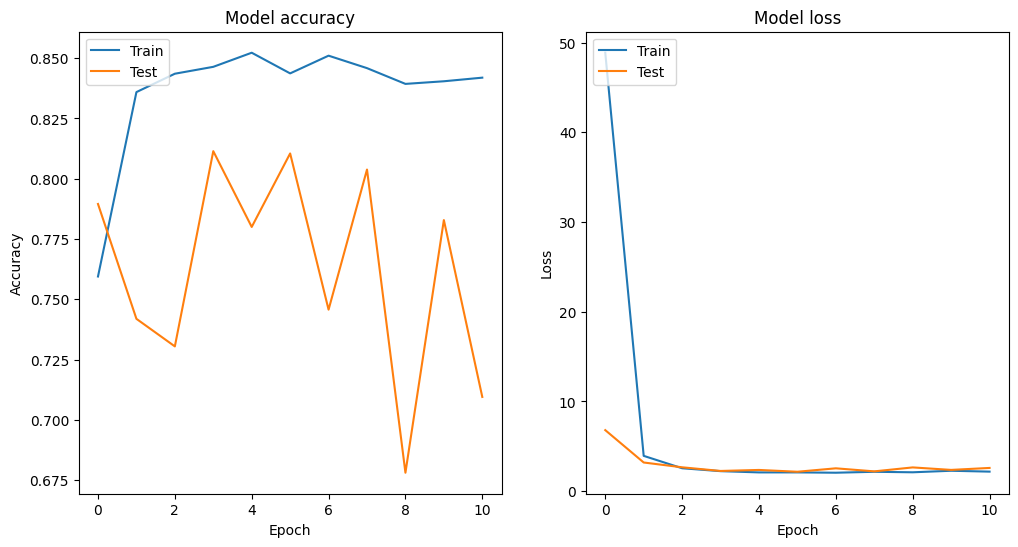

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()


17/17 ━━━━━━━━━━━━━━━━━━━━ 89s 3s/step


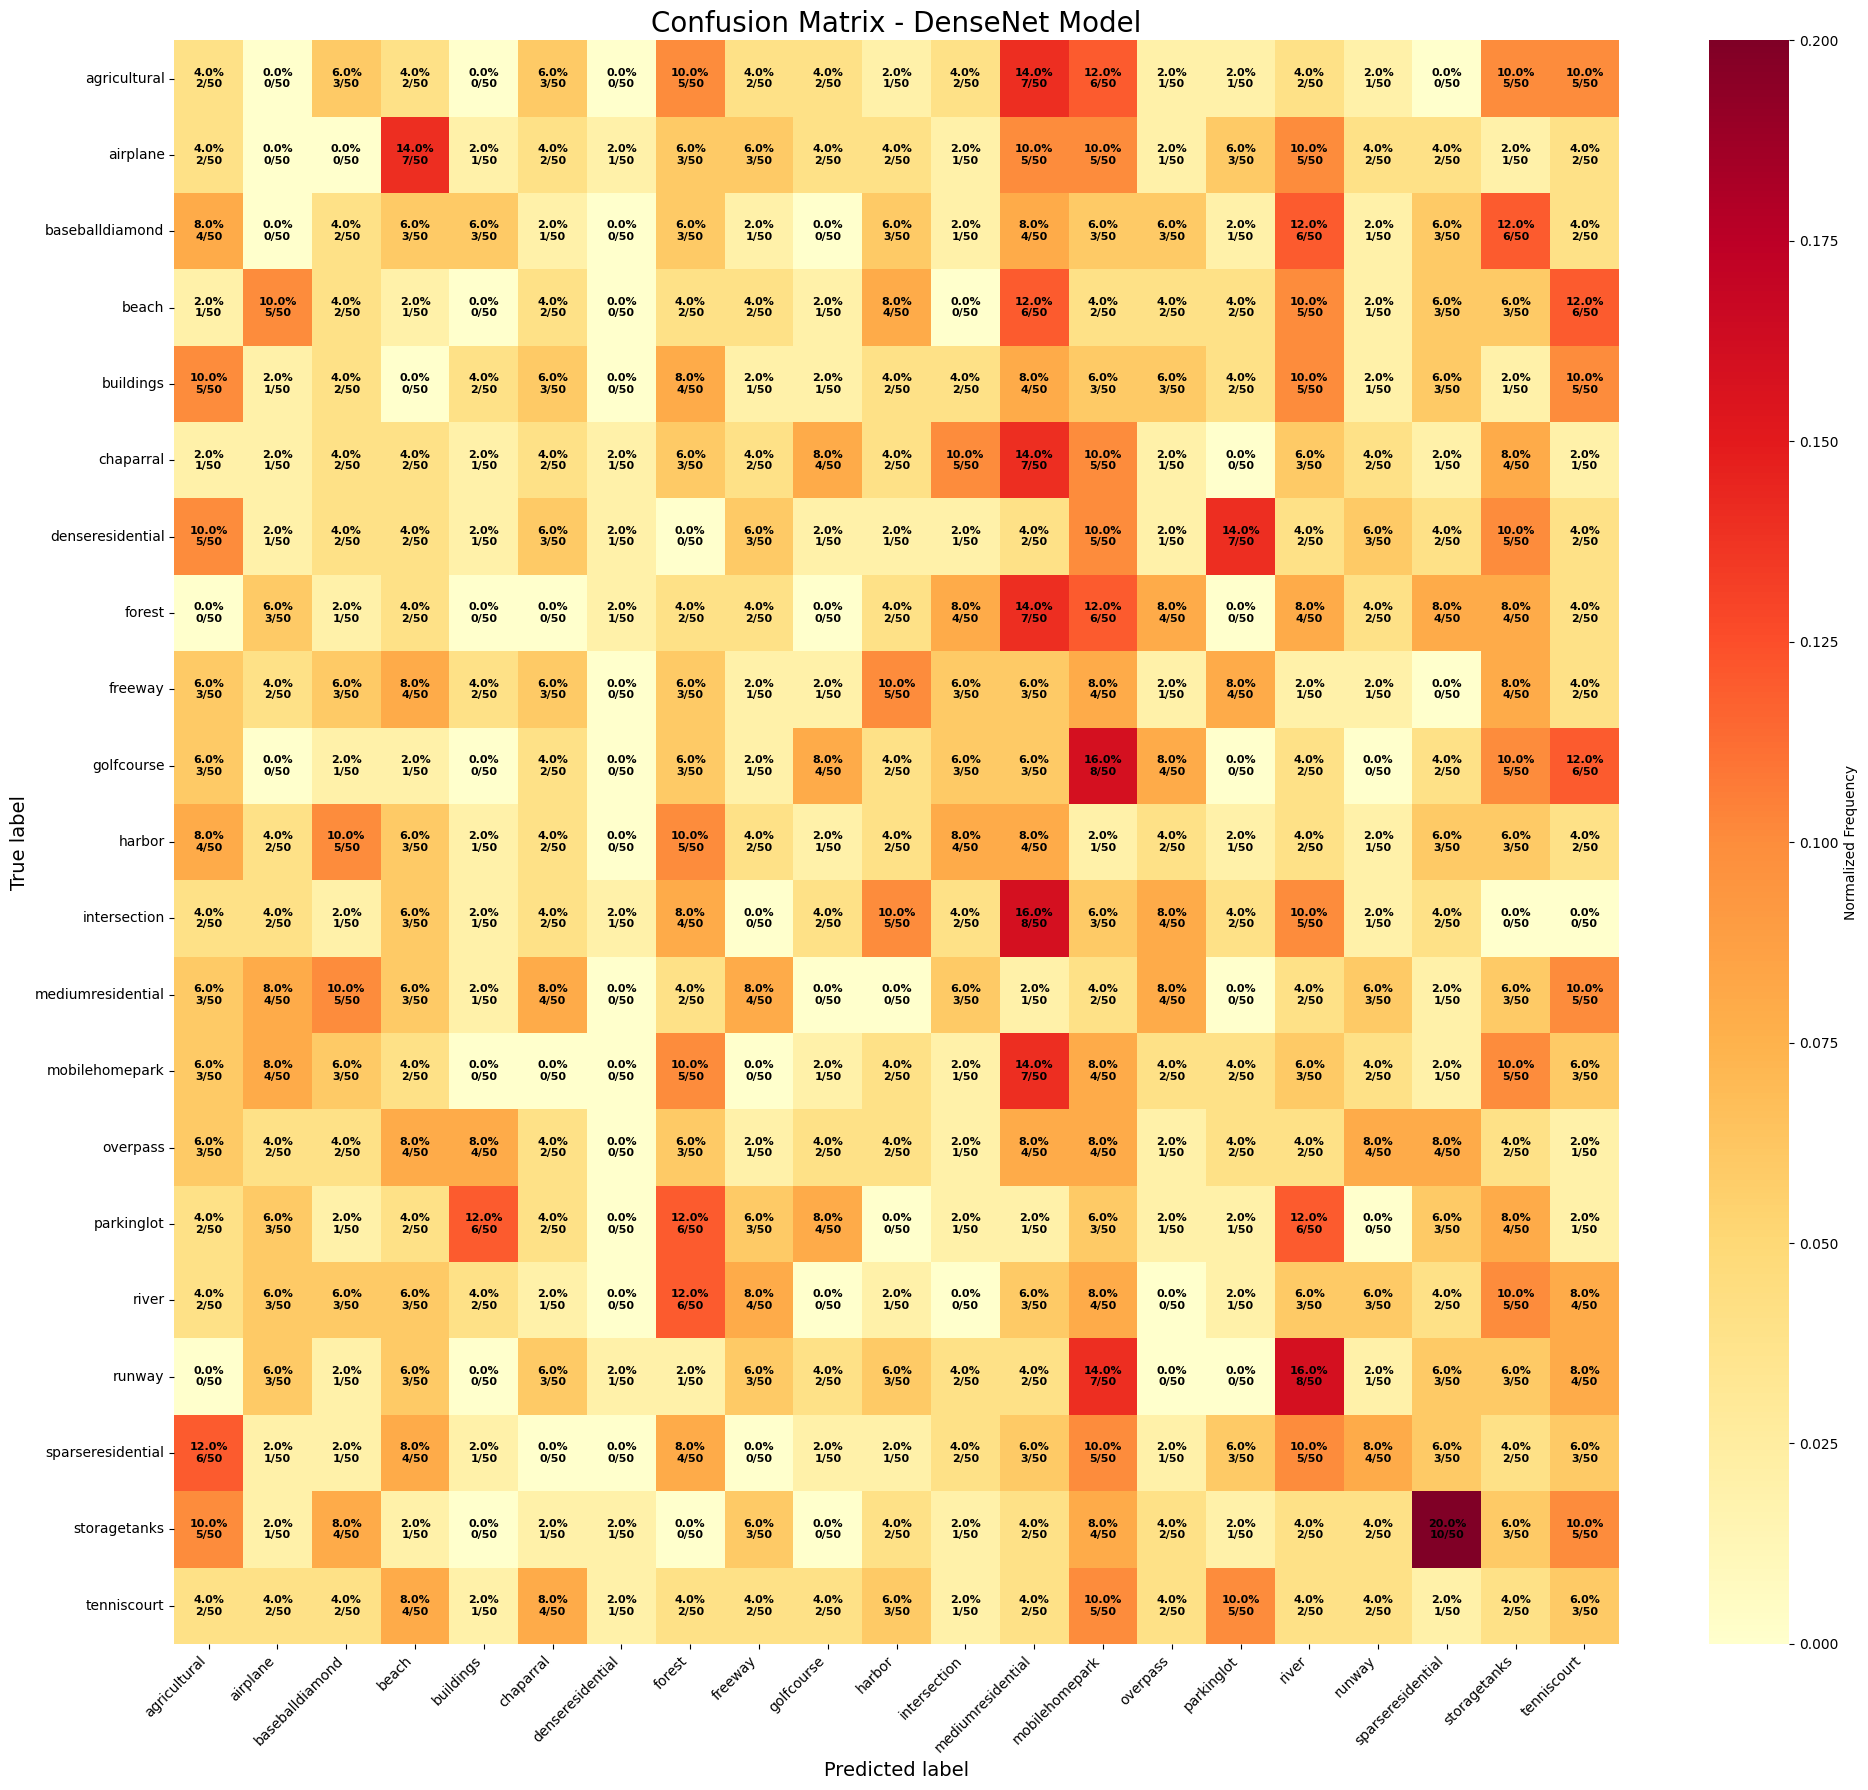

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.models import load_model

# Load the best model (assuming you've saved it during training)
model = load_model('models/best_denseNet_model.keras')

# Get predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get true labels
y_true = test_generator.classes

# Get class labels
class_labels = list(test_generator.class_indices.keys())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Create a figure and axis
plt.figure(figsize=(20, 18))

# Plot the heatmap
sns.heatmap(cm_normalized, annot=False, cmap='YlOrRd', 
            xticklabels=class_labels, yticklabels=class_labels,
            cbar_kws={'label': 'Normalized Frequency'})

# Customize the plot
plt.title('Confusion Matrix - DenseNet Model', fontsize=20)
plt.xlabel('Predicted label', fontsize=14)
plt.ylabel('True label', fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# Add text annotations for percentages and absolute values
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j+0.5, i+0.5, f"{cm_normalized[i, j]:.1%}\n{cm[i, j]}/{cm[i, :].sum()}", 
                 ha="center", va="center", color="black" if cm_normalized[i, j] < 0.5 else "white", 
                 fontsize=8, fontweight='bold')

plt.tight_layout()
plt.show()